In [1]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [3]:
# Pointers while performing transformation
# - Convert data to appropriate format
# - Normalize data
# - Apply Random Transformations within certain degree to prevent loss of information
# - Apply Random Resized Crop within certain degree to prevent loss of crucial information such as labels

train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(0.490, 0.247),

        # Additional Transformations (Only for train data)
        transforms.RandomAffine(degrees=(-5,5), translate=(0,0.05), scale=(0.9,1.1)),
        transforms.RandomResizedCrop((224,224), scale = (0.35,1))
    ]
)

# Do not apply train transformations to val data
val_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(0.0853, 0.234),
    ]
)

In [5]:
# load processed data from artifacts folder
train_dataset = torchvision.datasets.DatasetFolder(
    "../artifacts/pneumonia/processed/train/",
    loader=load_file,
    extensions="npy",
    transform=train_transform)

val_dataset = torchvision.datasets.DatasetFolder(
    "../artifacts/pneumonia/processed/val/",
    loader = load_file,
    extensions = "npy",
    transform = val_transforms
)

train_dataset

Dataset DatasetFolder
    Number of datapoints: 24000
    Root location: ../artifacts/pneumonia/processed/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.49, std=0.247)
               RandomAffine(degrees=[-5.0, 5.0], translate=(0, 0.05), scale=(0.9, 1.1))
               RandomResizedCrop(size=(224, 224), scale=(0.35, 1), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
           )

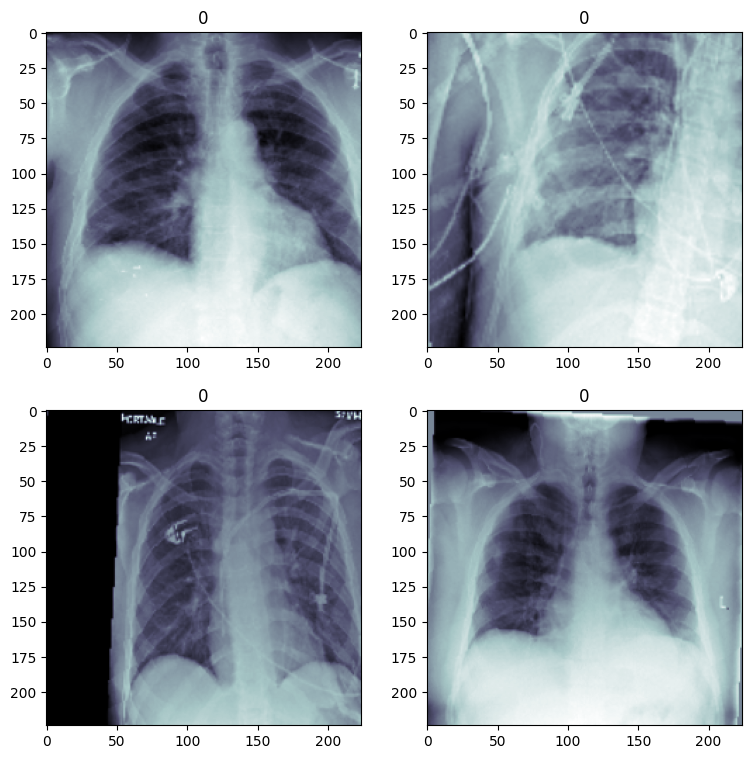

In [6]:
fig, axis = plt.subplots(2,2, figsize = (9,9))
axis = axis.flatten()

for i in range(len(axis)):
    random_index = np.random.randint(0,24000)
    x_ray, label = train_dataset[random_index]
    axis[i].imshow(x_ray[0], cmap="bone")
    axis[i].set_title(label)
    

In [7]:
# Configs
BATCH_SIZE = 64
NUM_WORKERS = 4

def loader_info(loader: torch.utils.data.DataLoader):
    print(f"Number of Batches: {len(loader)}")
    print(f"Size of each batch: {loader.batch_size}\n")

In [8]:
# Batch loader for datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= BATCH_SIZE, num_workers= NUM_WORKERS, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= BATCH_SIZE, num_workers= NUM_WORKERS, shuffle = False)

print(loader_info(train_loader))
print(loader_info(val_loader))


Number of Batches: 375
Size of each batch: 64

None
Number of Batches: 42
Size of each batch: 64

None


In [9]:
# Label count
np.unique(train_dataset.targets, return_counts=True) # Imbalanced data

(array([0, 1]), array([18593,  5407], dtype=int64))